# Optuna 사용법

- Optuna 설치
- Optuna 기본 사용법
- Sklearn, PyTorch, PyTorch Lightning 에서의 사용
    - 튜닝 알고리즘
- 내장 시각화 툴 이용하기
- Wandb 연동
---

### References
- https://optuna.readthedocs.io/
- https://towardsdatascience.com/why-is-everyone-at-kaggle-obsessed-with-optuna-for-hyperparameter-tuning-7608fdca337c
- https://medium.com/pytorch/using-optuna-to-optimize-pytorch-hyperparameters-990607385e36
---
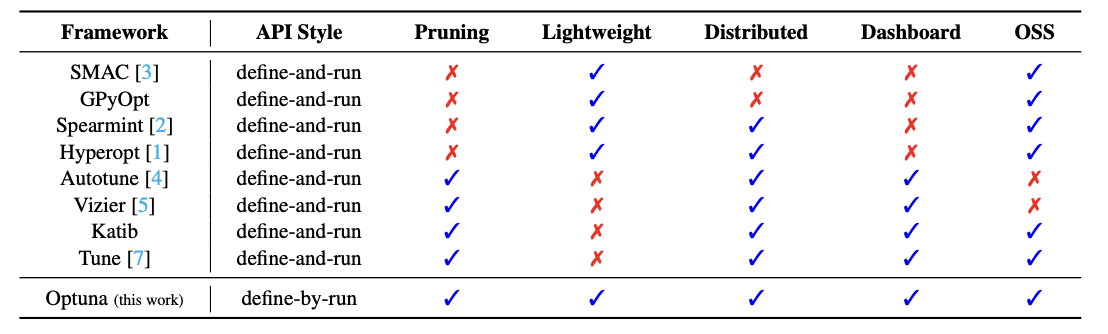


## Optuna 설치

In [1]:
!pip install optuna

     |████████████████████████████████| 308 kB 4.6 MB/s 
     |████████████████████████████████| 210 kB 10.4 MB/s 
     |████████████████████████████████| 80 kB 5.1 MB/s 
     |████████████████████████████████| 75 kB 3.0 MB/s 
     |████████████████████████████████| 49 kB 3.6 MB/s 
     |████████████████████████████████| 149 kB 10.6 MB/s 
     |████████████████████████████████| 113 kB 9.5 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=21f6b480173f0aeb5c974a091fcfd11e4b73c52afce5842c2d3aeac85a99c0b9
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [3]:
import matplotlib.pyplot as plt

## Optuna 기본 사용법

In [4]:
import optuna

def objective(trial):
    x = trial.suggest_float("x", -10, 10)
    return (x - 2) ** 2

- Optuna 컨벤션 - Optimize 할 함수를 objective 라고 네이밍
- suggest APIs 
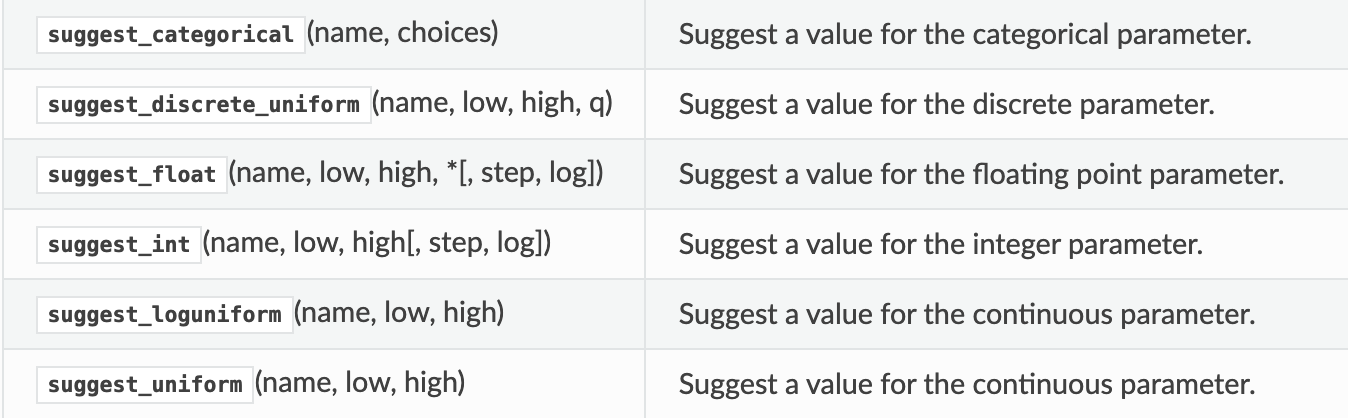

In [5]:
study = optuna.create_study()
study.optimize(objective, n_trials=150)

[I 2022-02-08 04:51:49,017] A new study created in memory with name: no-name-f70598b9-9a5f-4939-9d70-82873dcb0b3b
[I 2022-02-08 04:51:49,020] Trial 0 finished with value: 99.0368408693857 and parameters: {'x': -7.951725522208985}. Best is trial 0 with value: 99.0368408693857.
[I 2022-02-08 04:51:49,023] Trial 1 finished with value: 88.78015278250056 and parameters: {'x': -7.422322048332914}. Best is trial 1 with value: 88.78015278250056.
[I 2022-02-08 04:51:49,025] Trial 2 finished with value: 46.520961592351924 and parameters: {'x': -4.820627653841831}. Best is trial 2 with value: 46.520961592351924.
[I 2022-02-08 04:51:49,027] Trial 3 finished with value: 11.649908363504073 and parameters: {'x': -1.4131962093474897}. Best is trial 3 with value: 11.649908363504073.
[I 2022-02-08 04:51:49,030] Trial 4 finished with value: 0.5859093439550364 and parameters: {'x': 2.7654471529472406}. Best is trial 4 with value: 0.5859093439550364.
[I 2022-02-08 04:51:49,032] Trial 5 finished with value:

- Study: Optimization 세션 - set of trials

In [6]:
print("Best parameters: ", study.best_params)
print("Best metric observed:", study.best_value)

Best parameters:  {'x': 2.019195731664373}
Best metric observed: 0.00036847611413060987


## SKLearn 에서의 사용

In [7]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

X_train shape: (430, 13), X_valid shape: (76, 13)
y_train shape: (430,), y_valid shape: (76,)


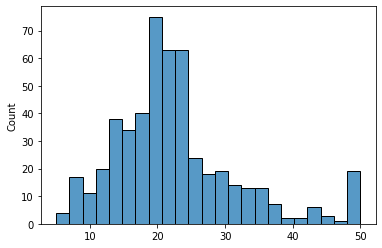

In [8]:
data = load_boston()
X = data.data
y = data.target

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=42)

print(f"X_train shape: {X_train.shape}, X_valid shape: {X_valid.shape}")
print(f"y_train shape: {y_train.shape}, y_valid shape: {y_valid.shape}")

import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(y)
plt.show()

In [9]:
def objective(trial: optuna.Trial, X_train, X_valid, y_train, y_valid):
    # 딕셔너리 형태로 파라미터 별 서치스페이스 인풋으로 사용
    params = {
        "n_estimators": trial.suggest_int(name="n_estimators", low=100, high=2000),
        "max_depth": trial.suggest_float("max_depth", 3, 8),
        "max_features": trial.suggest_categorical(
            "max_features", choices=["auto", "sqrt", "log2"]
        ),
        "n_jobs": -1,
        "random_state": 42,
    }
    # keyword argument 로 넘겨줌 // 하나씩 넘기기도 가능
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred)
    return mse

study = optuna.create_study(direction="minimize",)
# trial 외 다른 인자들 값 지정을 위한 lambda function
func = lambda trial: objective(trial, X_train=X_train,  X_valid=X_valid, y_train=y_train, y_valid=y_valid)
study.optimize(func, n_trials=50)

[I 2022-02-08 04:52:08,572] A new study created in memory with name: no-name-a5088723-9bb6-4227-b673-9bfdb257482f
[I 2022-02-08 04:52:09,783] Trial 0 finished with value: 5.072353604242626 and parameters: {'n_estimators': 553, 'max_depth': 7.8491697135108, 'max_features': 'log2'}. Best is trial 0 with value: 5.072353604242626.
[I 2022-02-08 04:52:12,598] Trial 1 finished with value: 8.133053310619445 and parameters: {'n_estimators': 1083, 'max_depth': 6.503231222974168, 'max_features': 'auto'}. Best is trial 0 with value: 5.072353604242626.
[I 2022-02-08 04:52:15,794] Trial 2 finished with value: 5.836935653735665 and parameters: {'n_estimators': 1610, 'max_depth': 6.098420021072494, 'max_features': 'log2'}. Best is trial 0 with value: 5.072353604242626.
[I 2022-02-08 04:52:19,470] Trial 3 finished with value: 5.219630130519197 and parameters: {'n_estimators': 1887, 'max_depth': 7.989397603144684, 'max_features': 'log2'}. Best is trial 0 with value: 5.072353604242626.
[I 2022-02-08 04:

In [10]:
print("Best parameters: ", study.best_params)
print("Best metric observed:", study.best_value)

Best parameters:  {'n_estimators': 326, 'max_depth': 7.297824078694367, 'max_features': 'log2'}
Best metric observed: 5.006173996464604


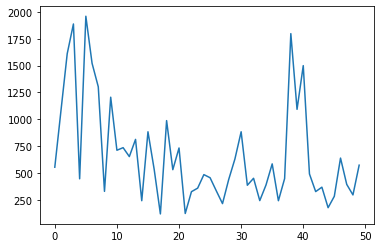

In [11]:
study.trials_dataframe().params_n_estimators.plot()

### 튜닝 알고리즘
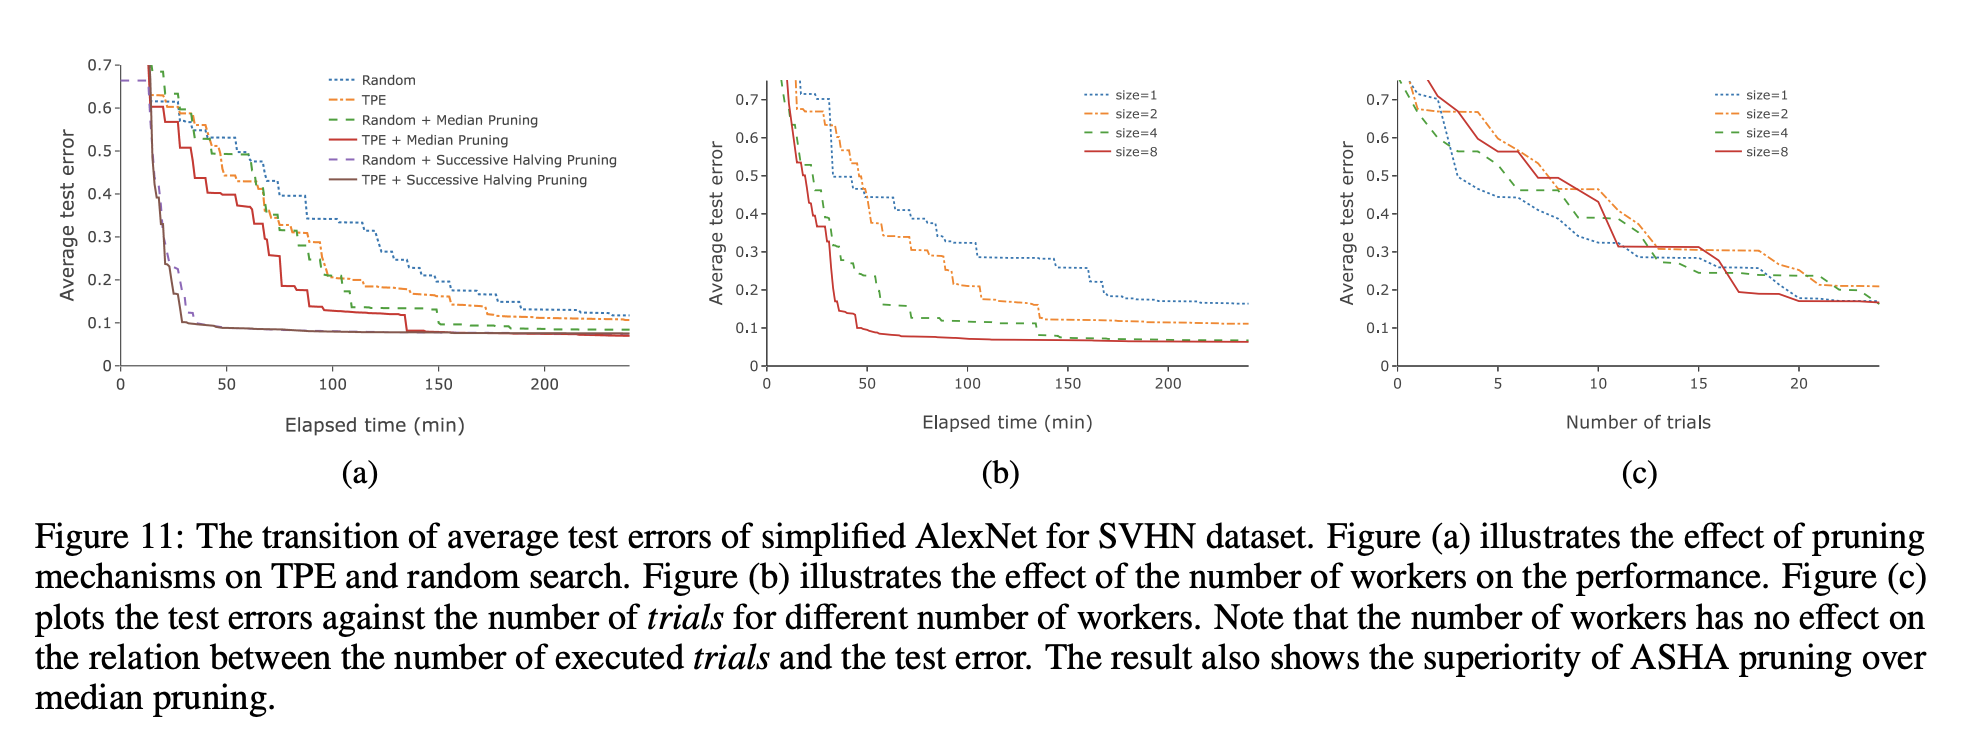

1. Tree-structured Parzen Estimator algorithm implemented in **optuna.samplers.TPESampler**

2. CMA-ES based algorithm implemented in **optuna.samplers.CmaEsSampler**

3. Grid Search implemented in **optuna.samplers.GridSampler**

4. Random Search implemented in **optuna.samplers.RandomSampler**

### CMA-ES 알고리즘
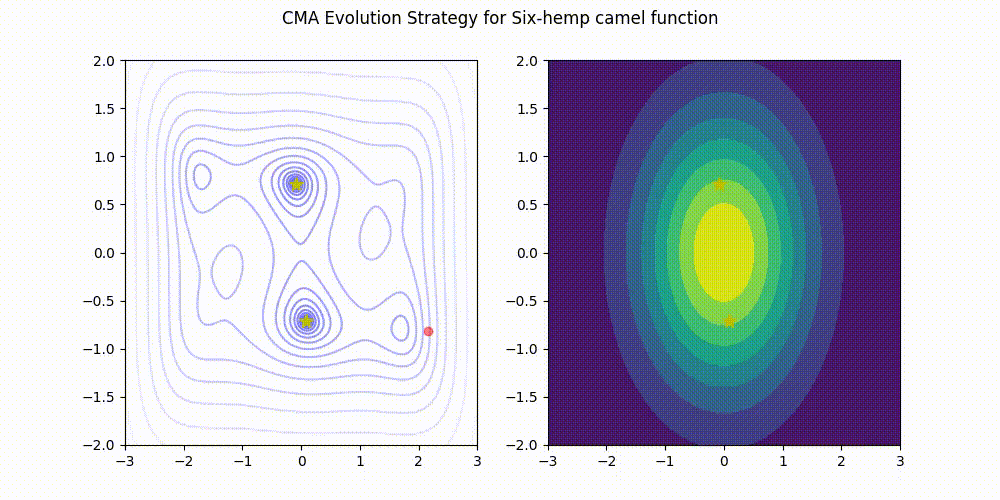
- https://medium.com/optuna/introduction-to-cma-es-sampler-ee68194c8f88
- https://github.com/CyberAgentAILab/cmaes
- https://arxiv.org/abs/2012.06932

### Random vs TPE sampler suggest 값 비교

In [17]:
def objective(trial):
    x = trial.suggest_float("x", -10, 10)
    y = trial.suggest_float("y", -10, 10)
    return x**2 + y**2

[I 2022-02-08 04:58:51,043] A new study created in memory with name: no-name-2334deda-2b2b-436c-abd3-b421914131ce
[I 2022-02-08 04:58:51,047] Trial 0 finished with value: 32.196286463176534 and parameters: {'x': -5.188468961333912, 'y': -2.296971114413746}. Best is trial 0 with value: 32.196286463176534.
[I 2022-02-08 04:58:51,050] Trial 1 finished with value: 57.38005338989139 and parameters: {'x': 5.489584775807245, 'y': -5.2196276092377225}. Best is trial 0 with value: 32.196286463176534.
[I 2022-02-08 04:58:51,057] Trial 2 finished with value: 13.014369959868535 and parameters: {'x': -2.126591961288189, 'y': 2.9140996191024406}. Best is trial 2 with value: 13.014369959868535.
[I 2022-02-08 04:58:51,059] Trial 3 finished with value: 68.19144279685162 and parameters: {'x': 1.904115477371434, 'y': 8.035283880839941}. Best is trial 2 with value: 13.014369959868535.
[I 2022-02-08 04:58:51,064] Trial 4 finished with value: 44.480507132335596 and parameters: {'x': 6.662461640222773, 'y': 

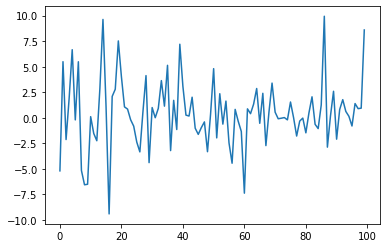

In [18]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=100, )
study.trials_dataframe().params_x.plot()

[I 2022-02-08 04:58:56,393] A new study created in memory with name: no-name-a208b51d-8086-45e2-b17d-4eed44bc9e03
[I 2022-02-08 04:58:56,396] Trial 0 finished with value: 143.8683644623097 and parameters: {'x': 7.00526518348061, 'y': 9.736253086861705}. Best is trial 0 with value: 143.8683644623097.
[I 2022-02-08 04:58:56,398] Trial 1 finished with value: 15.32565709135425 and parameters: {'x': 3.9004967007107556, 'y': -0.3343390182116952}. Best is trial 1 with value: 15.32565709135425.
[I 2022-02-08 04:58:56,401] Trial 2 finished with value: 109.37170698724074 and parameters: {'x': -6.921117316536673, 'y': 7.840270536019592}. Best is trial 1 with value: 15.32565709135425.
[I 2022-02-08 04:58:56,404] Trial 3 finished with value: 24.390597414409292 and parameters: {'x': -4.831022798903328, 'y': -1.025580874863385}. Best is trial 1 with value: 15.32565709135425.
[I 2022-02-08 04:58:56,407] Trial 4 finished with value: 95.70172855534044 and parameters: {'x': 9.677498874156498, 'y': 1.4309

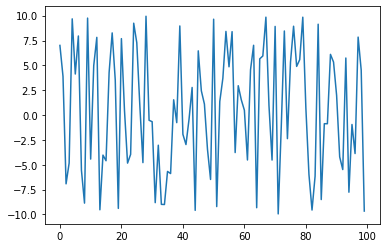

In [19]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=100, )
study.trials_dataframe().params_x.plot()

### (SKLearn) CMA-ES 적용

In [23]:
def objective(trial: optuna.Trial, X_train, X_valid, y_train, y_valid):
    # 딕셔너리 형태로 파라미터 별 서치스페이스 인풋으로 사용
    params = {
        "n_estimators": trial.suggest_int(name="n_estimators", low=100, high=2000),
        "max_depth": trial.suggest_float("max_depth", 3, 8),
        "max_features": trial.suggest_categorical(
            "max_features", choices=["auto", "sqrt", "log2"]
        ),
        "n_jobs": -1,
        "random_state": 42,
    }
    # keyword argument 로 넘겨줌 // 하나씩 넘기기도 가능
    model = RandomForestRegressor(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    mse = mean_squared_error(y_valid, y_pred)
    return mse
    
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.CmaEsSampler(warn_independent_sampling=False)) # sampler 지정, CMA-ES 샘플러 사용시 categorical suggest는 random sampler 방식 이용
func = lambda trial: objective(trial, X_train=X_train,  X_valid=X_valid, y_train=y_train, y_valid=y_valid)
study.optimize(func, n_trials=30,)

[I 2022-02-08 05:13:36,958] A new study created in memory with name: no-name-5b6f953c-536d-434a-80b2-a444079bbc80
[I 2022-02-08 05:13:40,614] Trial 0 finished with value: 8.240595225862403 and parameters: {'n_estimators': 809, 'max_depth': 6.971648608730237, 'max_features': 'auto'}. Best is trial 0 with value: 8.240595225862403.
[I 2022-02-08 05:13:42,606] Trial 1 finished with value: 8.177795200704354 and parameters: {'n_estimators': 1049, 'max_depth': 4.865432430518783, 'max_features': 'sqrt'}. Best is trial 1 with value: 8.177795200704354.
[I 2022-02-08 05:13:44,696] Trial 2 finished with value: 6.549666733680651 and parameters: {'n_estimators': 1051, 'max_depth': 5.323013642835702, 'max_features': 'sqrt'}. Best is trial 2 with value: 6.549666733680651.
[I 2022-02-08 05:13:46,988] Trial 3 finished with value: 9.728774396830405 and parameters: {'n_estimators': 1050, 'max_depth': 4.100371467935102, 'max_features': 'auto'}. Best is trial 2 with value: 6.549666733680651.
[I 2022-02-08 0

In [24]:
print("Best parameters: ", study.best_params)
print("Best metric observed:", study.best_value)

Best parameters:  {'n_estimators': 1052, 'max_depth': 6.81886463589106, 'max_features': 'log2'}
Best metric observed: 5.881384667158753


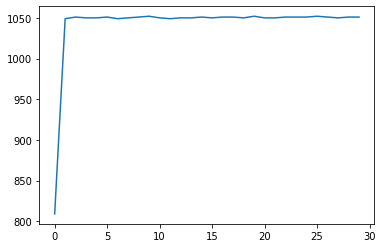

In [25]:
study.trials_dataframe().params_n_estimators.plot()

## PyTorch 에서의 사용

- 간단한 FashinMNIST 예제

In [26]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
from sklearn.metrics import accuracy_score

# 시드 고정
def seed_everything(seed=99):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  
seed_everything()

In [27]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CLASSES = 10
EPOCHS = 10
LOG_INTERVAL = 10

print(DEVICE)

def get_mnist(BATCHSIZE):
    # Load FashionMNIST dataset.
    # Optimize batch size
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('./mnist_data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('./mnist_data', train=False, transform=transforms.ToTensor()),
        batch_size=32,
        shuffle=True,
    )

    return train_loader, valid_loader

cuda


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./mnist_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./mnist_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./mnist_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./mnist_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/FashionMNIST/raw



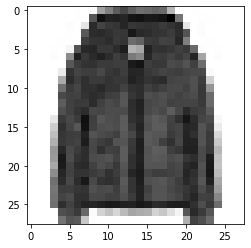

(28, 28)


In [28]:
# Show sample

import matplotlib.pyplot as plt

sample_tr_loader, sample_vl_loader = get_mnist(1)
sample, _ = next(iter(sample_tr_loader))
sample = sample.squeeze(0).squeeze(0).cpu().numpy()
plt.imshow(sample, cmap='Greys')
plt.show()
print(sample.shape)

In [29]:
class Network(nn.Module):
    def __init__(self, trial):
        super(Network, self).__init__()

        n_layers = trial.suggest_int("n_layers", 1, 3)
        layers = []

        in_features = 28 * 28
        for i in range(n_layers):
            out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
            layers.append(nn.Linear(in_features, out_features))
            layers.append(nn.ReLU())
            
            p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
            layers.append(nn.Dropout(p))

            in_features = out_features
        layers.append(nn.Linear(in_features, CLASSES))
        layers.append(nn.LogSoftmax(dim=1))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        return self.layers(x)

###Pruning 적용

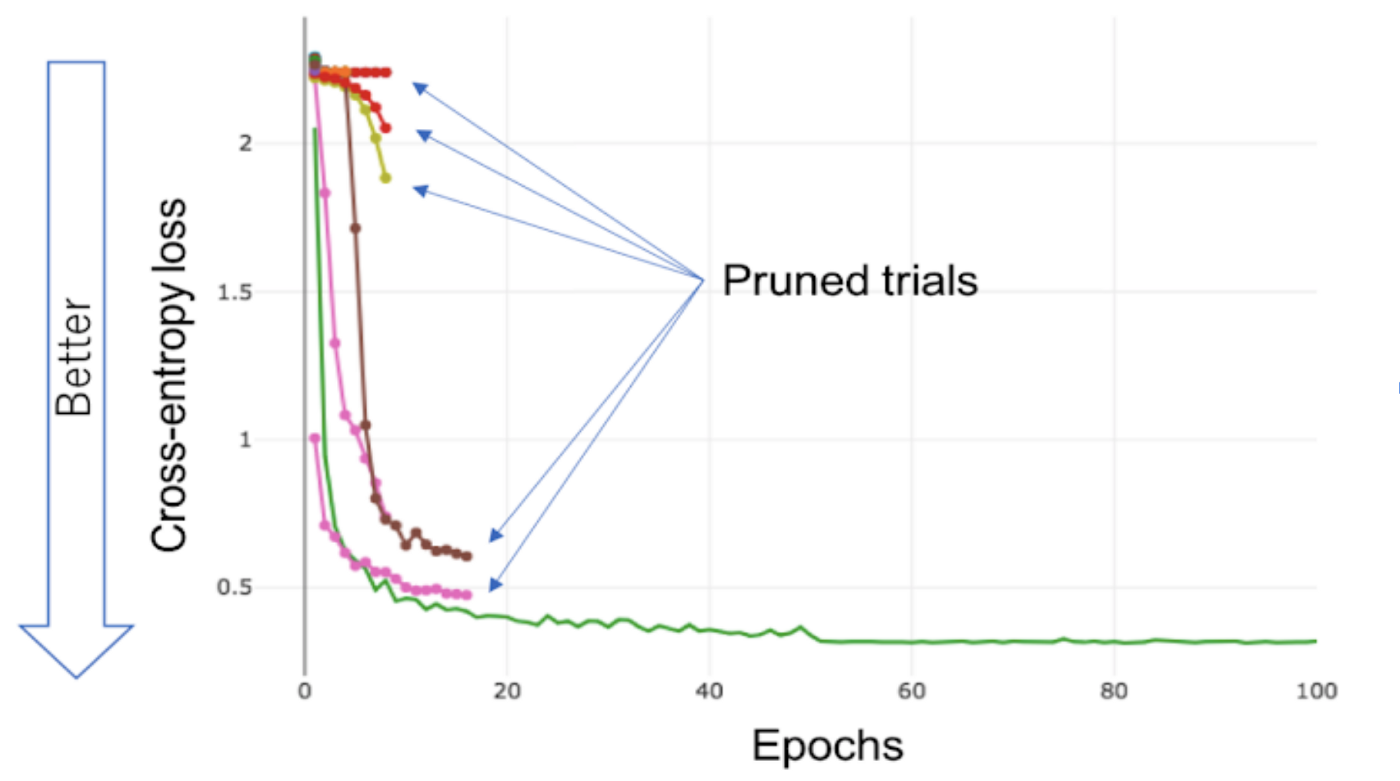

- Early stopping 과 같이 동작

- Optuna 제공 pruning 알고리즘
    - Asynchronous Successive Halving algorithm implemented in **optuna.pruners.SuccessiveHalvingPruner**

    - Hyperband algorithm implemented in **optuna.pruners.HyperbandPruner**

    - Median pruning algorithm implemented in **optuna.pruners.MedianPruner**

    - Threshold pruning algorithm implemented in **optuna.pruners.ThresholdPruner**

- Pruning 을 사용하기 위해선, report() 와 should_prune() 을 매스텝 call 해줘야함.

In [ ]:
def objective(trial):

    # Generate the model.
    model = Network(trial)
    model.to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Set trial batch size
    BATCHSIZE = trial.suggest_int("batch_size", 4, 128)
    N_TRAIN_EXAMPLES = BATCHSIZE * 30
    N_VALID_EXAMPLES = BATCHSIZE * 10

    # Get the FashionMNIST dataset.
    train_loader, valid_loader = get_mnist(BATCHSIZE)

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        total_preds = []
        total_targets = []
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                total_preds.extend(pred.cpu().numpy().reshape(-1))
                total_targets.extend(target.cpu().numpy().reshape(-1))

        accuracy = accuracy_score(total_targets, total_preds)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize", 
                            sampler=optuna.samplers.TPESampler(), # if not set, TPESampler (single-objective optimization) / NSGAIISampler (multi-objective optimization) as default
                            pruner=optuna.pruners.SuccessiveHalvingPruner() # if not set, MedianPruner as default
                            )
study.optimize(objective, n_trials=50, timeout=600)

[I 2022-02-07 15:46:39,881] A new study created in memory with name: no-name-e5543951-a120-48cf-ad01-e654f0d0b4ea
[I 2022-02-07 15:46:53,791] Trial 0 finished with value: 0.071875 and parameters: {'n_layers': 3, 'n_units_l0': 63, 'dropout_l0': 0.463955177785746, 'n_units_l1': 121, 'dropout_l1': 0.4823012484280127, 'n_units_l2': 21, 'dropout_l2': 0.21607678543827968, 'optimizer': 'SGD', 'lr': 2.0533768660065575e-05, 'batch_size': 92}. Best is trial 0 with value: 0.071875.
[I 2022-02-07 15:46:56,303] Trial 1 finished with value: 0.065625 and parameters: {'n_layers': 2, 'n_units_l0': 62, 'dropout_l0': 0.36681563024477926, 'n_units_l1': 119, 'dropout_l1': 0.2522672462150332, 'optimizer': 'SGD', 'lr': 6.0719568045116695e-05, 'batch_size': 39}. Best is trial 0 with value: 0.071875.
[I 2022-02-07 15:47:00,674] Trial 2 finished with value: 0.08125 and parameters: {'n_layers': 3, 'n_units_l0': 24, 'dropout_l0': 0.31562555932939906, 'n_units_l1': 35, 'dropout_l1': 0.439452530231837, 'n_units_l2'

In [ ]:
print("Best parameters: ", study.best_params)
print("Best metric observed:", study.best_value)

Best parameters:  {'n_layers': 1, 'n_units_l0': 91, 'dropout_l0': 0.36247139947978413, 'optimizer': 'RMSprop', 'lr': 0.0011714246836980254, 'batch_size': 91}
Best metric observed: 0.840625


In [ ]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_batch_size,params_dropout_l0,params_dropout_l1,params_dropout_l2,params_lr,params_n_layers,params_n_units_l0,params_n_units_l1,params_n_units_l2,params_optimizer,system_attrs_completed_rung_0,system_attrs_completed_rung_1,state
0,0,0.071875,2022-02-07 15:46:39.884907,2022-02-07 15:46:53.790541,0 days 00:00:13.905634,92,0.463955,0.482301,0.216077,0.000021,3,63,121.0,21.0,SGD,NaN,NaN,COMPLETE
1,1,0.065625,2022-02-07 15:46:53.793258,2022-02-07 15:46:56.302846,0 days 00:00:02.509588,39,0.366816,0.252267,NaN,0.000061,2,62,119.0,NaN,SGD,0.071875,0.093750,COMPLETE
2,2,0.081250,2022-02-07 15:46:56.306227,2022-02-07 15:47:00.674210,0 days 00:00:04.367983,84,0.315626,0.439453,0.239603,0.002369,3,24,35.0,65.0,SGD,0.084375,0.093750,COMPLETE
3,3,0.515625,2022-02-07 15:47:00.678138,2022-02-07 15:47:06.476481,0 days 00:00:05.798343,123,0.230225,0.291140,0.251453,0.057076,3,23,94.0,63.0,SGD,0.237500,0.496875,COMPLETE
4,4,0.275000,2022-02-07 15:47:06.478723,2022-02-07 15:47:08.028261,0 days 00:00:01.549538,46,0.256486,0.308793,0.307374,0.081465,3,106,127.0,114.0,RMSprop,0.281250,0.275000,PRUNED
5,5,0.365625,2022-02-07 15:47:08.030546,2022-02-07 15:47:10.439476,0 days 00:00:02.408930,96,0.233623,0.257492,NaN,0.014819,2,126,77.0,NaN,SGD,0.321875,0.365625,PRUNED
6,6,0.650000,2022-02-07 15:47:10.441068,2022-02-07 15:47:12.885297,0 days 00:00:02.444229,30,0.249251,0.433390,NaN,0.000295,2,37,67.0,NaN,Adam,0.446875,0.584375,COMPLETE
7,7,0.134375,2022-02-07 15:47:12.889936,2022-02-07 15:47:13.525974,0 days 00:00:00.636038,53,0.400639,0.498825,NaN,0.001928,2,30,74.0,NaN,SGD,0.134375,NaN,PRUNED
8,8,0.106250,2022-02-07 15:47:13.527667,2022-02-07 15:47:14.371405,0 days 00:00:00.843738,77,0.448696,0.218655,0.433400,0.001890,3,123,48.0,10.0,SGD,0.106250,NaN,PRUNED
9,9,0.581250,2022-02-07 15:47:14.372999,2022-02-07 15:47:15.773542,0 days 00:00:01.400543,40,0.254942,0.411479,NaN,0.000377,2,32,108.0,NaN,Adam,0.409375,0.581250,PRUNED


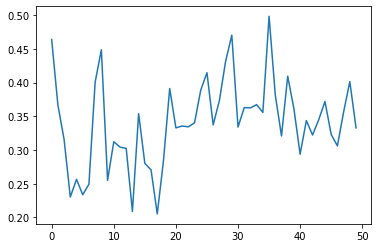

In [ ]:
study.trials_dataframe().params_dropout_l0.plot()

In [ ]:
study = optuna.create_study(direction="maximize", 
                            sampler=optuna.samplers.CmaEsSampler(), # if not set, TPESampler (single-objective optimization) / NSGAIISampler (multi-objective optimization) as default
                            pruner=optuna.pruners.SuccessiveHalvingPruner()
                            )
study.optimize(objective, n_trials=50, timeout=600)

[I 2021-09-10 04:58:49,992] A new study created in memory with name: no-name-13ab85c5-838e-4a4a-8b13-ec4e5b1959ea
[I 2021-09-10 04:58:55,369] Trial 0 finished with value: 0.128125 and parameters: {'n_layers': 2, 'n_units_l0': 98, 'dropout_l0': 0.27070619897621095, 'n_units_l1': 99, 'dropout_l1': 0.316832276414333, 'optimizer': 'SGD', 'lr': 9.099265284254874e-05, 'batch_size': 116}. Best is trial 0 with value: 0.128125.
[W 2021-09-10 04:58:55,376] The parameter 'optimizer' in trial#1 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[I 2021-09-10 04:58:58,800] Trial 1 finished with value: 0.24375 and parameters: {'n_layers': 2, 'n_units_l0': 66, 'dropout_l0': 0.366552562

In [ ]:
print("Best parameters: ", study.best_params)
print("Best metric observed:", study.best_value)

Best parameters:  {'n_layers': 2, 'n_units_l0': 66, 'dropout_l0': 0.3678958528487093, 'n_units_l1': 66, 'dropout_l1': 0.351104259463088, 'optimizer': 'RMSprop', 'lr': 0.0009987428716976088, 'batch_size': 66}
Best metric observed: 0.815625


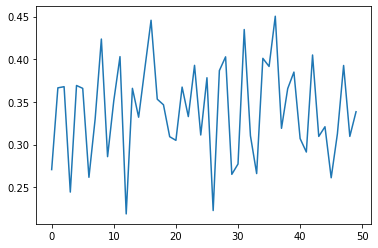

In [ ]:
study.trials_dataframe().params_dropout_l0.plot()

## PyTorch Lightning

In [ ]:
!pip install pytorch-lightning 

     |████████████████████████████████| 527 kB 12.5 MB/s 
     |████████████████████████████████| 133 kB 45.8 MB/s 
     |████████████████████████████████| 596 kB 45.3 MB/s 
     |████████████████████████████████| 397 kB 47.9 MB/s 
     |████████████████████████████████| 829 kB 52.3 MB/s 
     |████████████████████████████████| 952 kB 24.1 MB/s 
     |████████████████████████████████| 1.1 MB 8.7 MB/s 
     |████████████████████████████████| 94 kB 2.0 MB/s 
     |████████████████████████████████| 144 kB 41.4 MB/s 
     |████████████████████████████████| 271 kB 21.4 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=400be7b136712d6f96e3fa221f8592ddb5d07e8cf6b9c93fb8e5b7b7a02ed542
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: setuptools
    Found existing installation: setuptools 57.4.0
    Uninstalling setuptools-57.4.0:
      Successful

In [ ]:
import os
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from optuna.integration import PyTorchLightningPruningCallback
from typing import List
from typing import Optional

PERCENT_VALID_EXAMPLES = 0.1
BATCHSIZE = 128
CLASSES = 10
EPOCHS = 10
DIR = os.getcwd()

In [ ]:
from torch.utils.data import DataLoader

class Net(nn.Module):
    def __init__(self, dropout: float, output_dims: List[int]):
        super().__init__()
        layers: List[nn.Module] = []

        input_dim: int = 28 * 28
        for output_dim in output_dims:
            layers.append(nn.Linear(input_dim, output_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = output_dim

        layers.append(nn.Linear(input_dim, CLASSES))

        self.layers: nn.Module = nn.Sequential(*layers)

    def forward(self, data: torch.Tensor) -> torch.Tensor:
        logits = self.layers(data)
        return F.log_softmax(logits, dim=1)

In [ ]:
class LightningNet(pl.LightningModule):
    def __init__(self, dropout: float, output_dims: List[int]):
        super().__init__()
        self.model = Net(dropout, output_dims)

    def forward(self, data: torch.Tensor) -> torch.Tensor:
        return self.model(data.view(-1, 28 * 28))

    def training_step(self, batch, batch_idx: int) -> torch.Tensor:
        data, target = batch
        output = self(data)
        return F.nll_loss(output, target)

    def validation_step(self, batch, batch_idx: int) -> None:
        data, target = batch
        output = self(data)
        pred = output.argmax(dim=1, keepdim=True)
        accuracy = pred.eq(target.view_as(pred)).float().mean()
        self.log("val_acc", accuracy)
        self.log("hp_metric", accuracy, on_step=False, on_epoch=True)

    def configure_optimizers(self) -> optim.Optimizer:
        return optim.Adam(self.model.parameters())

In [ ]:
class FashionMNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str, batch_size: int):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

    def setup(self, stage: Optional[str] = None) -> None:
        self.mnist_test = datasets.FashionMNIST(
            self.data_dir, train=False, download=True, transform=transforms.ToTensor()
        )
        mnist_full = datasets.FashionMNIST(
            self.data_dir, train=True, download=True, transform=transforms.ToTensor()
        )
        self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.mnist_train, batch_size=self.batch_size, shuffle=True, pin_memory=True
        )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            self.mnist_val, batch_size=self.batch_size, shuffle=False, pin_memory=True
        )

    def test_dataloader(self) -> DataLoader:
        return DataLoader(
            self.mnist_test, batch_size=self.batch_size, shuffle=False, pin_memory=True
        )

In [ ]:
def objective(trial: optuna.trial.Trial) -> float:

    # We optimize the number of layers, hidden units in each layer and dropouts.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.2, 0.5)
    output_dims = [
        trial.suggest_int("n_units_l{}".format(i), 4, 128, log=True) for i in range(n_layers)
    ]

    model = LightningNet(dropout, output_dims)
    datamodule = FashionMNISTDataModule(data_dir=DIR, batch_size=BATCHSIZE)

    trainer = pl.Trainer(
        logger=True,
        limit_val_batches=PERCENT_VALID_EXAMPLES,
        checkpoint_callback=False,
        max_epochs=EPOCHS,
        gpus=1 if torch.cuda.is_available() else None,
        callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_acc")], # Pruning callback
    )
    hyperparameters = dict(n_layers=n_layers, dropout=dropout, output_dims=output_dims)
    trainer.logger.log_hyperparams(hyperparameters)
    trainer.fit(model, datamodule=datamodule)

    return trainer.callback_metrics["val_acc"].item()

In [ ]:
study = optuna.create_study(direction="maximize", )
study.optimize(objective, n_trials=100, timeout=600)

[I 2022-02-07 15:51:58,479] A new study created in memory with name: no-name-bfe5780c-85c0-43ef-bcd6-5a71579542d0
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 7.6 K 
-------------------------------
7.6 K     Trainable params
0         Non-trainable params
7.6 K     Total params
0.031     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-02-07 15:53:42,746] Trial 0 finished with value: 0.560546875 and parameters: {'n_layers': 3, 'dropout': 0.4286123200297424, 'n_units_l0': 5, 'n_units_l1': 73, 'n_units_l2': 39}. Best is trial 0 with value: 0.560546875.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 89.5 K
-------------------------------
89.5 K    Trainable params
0         Non-trainable params
89.5 K    Total params
0.358     Total estimated model param

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-02-07 15:55:21,362] Trial 1 finished with value: 0.880859375 and parameters: {'n_layers': 2, 'dropout': 0.2028343303311597, 'n_units_l0': 109, 'n_units_l1': 33}. Best is trial 1 with value: 0.880859375.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 13.2 K
-------------------------------
13.2 K    Trainable params
0         Non-trainable params
13.2 K    Total params
0.053     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-02-07 15:56:57,117] Trial 2 finished with value: 0.845703125 and parameters: {'n_layers': 2, 'dropout': 0.2598267423704766, 'n_units_l0': 16, 'n_units_l1': 23}. Best is trial 1 with value: 0.880859375.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 8.1 K 
-------------------------------
8.1 K     Trainable params
0         Non-trainable params
8.1 K     Total params
0.032     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-02-07 15:58:34,314] Trial 3 finished with value: 0.40234375 and parameters: {'n_layers': 3, 'dropout': 0.4410606982331948, 'n_units_l0': 6, 'n_units_l1': 40, 'n_units_l2': 60}. Best is trial 1 with value: 0.880859375.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 86.7 K
-------------------------------
86.7 K    Trainable params
0         Non-trainable params
86.7 K    Total params
0.347     Total estimated model params

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-02-07 16:00:05,739] Trial 4 finished with value: 0.875 and parameters: {'n_layers': 1, 'dropout': 0.458064254035055, 'n_units_l0': 109}. Best is trial 1 with value: 0.880859375.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 41.4 K
-------------------------------
41.4 K    Trainable params
0         Non-trainable params
41.4 K    Total params
0.165     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-02-07 16:01:36,969] Trial 5 finished with value: 0.865234375 and parameters: {'n_layers': 1, 'dropout': 0.28541471128370655, 'n_units_l0': 52}. Best is trial 1 with value: 0.880859375.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 41.4 K
-------------------------------
41.4 K    Trainable params
0         Non-trainable params
41.4 K    Total params
0.165     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[I 2022-02-07 16:01:37,222] Trial 6 pruned. Trial was pruned at epoch 0.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 3.2 K 
-------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

[I 2022-02-07 16:01:55,663] Trial 7 pruned. Trial was pruned at epoch 1.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | Net  | 77.5 K
-------------------------------
77.5 K    Trainable params
0         Non-trainable params
77.5 K    Total params
0.310     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  step


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

[I 2022-02-07 16:03:30,776] Trial 8 finished with value: 0.873046875 and parameters: {'n_layers': 3, 'dropout': 0.3759076604532343, 'n_units_l0': 84, 'n_units_l1': 72, 'n_units_l2': 66}. Best is trial 1 with value: 0.880859375.


In [ ]:
print("Best parameters: ", study.best_params)
print("Best metric observed:", study.best_value)

Best parameters:  {'n_layers': 1, 'dropout': 0.4239162984164312, 'n_units_l0': 14}
Best metric observed: 0.880859375


## 내장 시각화 툴 이용하기

In [ ]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

In [ ]:
plot_intermediate_values(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_param_importances(study)

## Wandb 연동

In [ ]:
!pip install wandb

     |████████████████████████████████| 1.7 MB 4.1 MB/s 
     |████████████████████████████████| 179 kB 56.4 MB/s 
     |████████████████████████████████| 97 kB 6.7 MB/s 
     |████████████████████████████████| 133 kB 52.5 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=bca1e262a581a5eeb9f434f52a8cff6921efb4e00969e359b80098ee4d110542
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=140c5d8e7d4429232a7fbd9a628a2c9b0bf3fb284f6fd0e98dfda8dbdfc78c96
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [ ]:
def objective(trial):

    # Generate the model.
    model = Network(trial)
    model.to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Set trial batch size
    BATCHSIZE = trial.suggest_int("batch_size", 4, 128)
    N_TRAIN_EXAMPLES = BATCHSIZE * 30
    N_VALID_EXAMPLES = BATCHSIZE * 10

    # Get the FashionMNIST dataset.
    train_loader, valid_loader = get_mnist(BATCHSIZE)

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        total_preds = []
        total_targets = []
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                total_preds.extend(pred.cpu().numpy().reshape(-1))
                total_targets.extend(target.cpu().numpy().reshape(-1))

        accuracy = accuracy_score(total_targets, total_preds)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
import wandb
from optuna.integration.wandb import WeightsAndBiasesCallback

wandb_kwargs = {"project": "optuna_study_0910",}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs, metric_name="accuracy")

study = optuna.create_study(direction="maximize", 
                            sampler=optuna.samplers.CmaEsSampler(), # if not set, TPESampler (single-objective optimization) / NSGAIISampler (multi-objective optimization) as default
                            pruner=optuna.pruners.SuccessiveHalvingPruner()
                            )
study.optimize(objective, n_trials=50, timeout=600, callbacks=[wandbc])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: ExperimentalWarning:

WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.



<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


[I 2021-09-10 05:07:24,677] A new study created in memory with name: no-name-04a187be-21b2-45dc-8230-9d0692c35620
[I 2021-09-10 05:07:31,441] Trial 0 finished with value: 0.6875 and parameters: {'n_layers': 1, 'n_units_l0': 16, 'dropout_l0': 0.4408937176050698, 'optimizer': 'Adam', 'lr': 0.00040897524409457713, 'batch_size': 91}. Best is trial 0 with value: 0.6875.
[W 2021-09-10 05:07:31,449] The parameter 'n_units_l1' in trial#1 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSampler` does not support dynamic search space or `CategoricalDistribution`. You can suppress this warning by setting `warn_independent_sampling` to `False` in the constructor of `CmaEsSampler`, if this independent sampling is intended behavior.
[W 2021-09-10 05:07:31,452] The parameter 'dropout_l1' in trial#1 is sampled independently by using `RandomSampler` instead of `CmaEsSampler` (optimization performance may be degraded). `CmaEsSa

---

# (실습) CNN 하이퍼 파라미터 튜닝 - PyTorch

- 우리는 위에서 fully connected 구조의 모델로 FashionMnist 분류 문제를 해결하였습니다.
- Conv2d 레이어를 이용하여 CNN 기반 모델을 만들고 레이어 개수나 커널 사이즈, 채널 사이즈등을 자유롭게 튜닝해보며 성능을 높여 봅시다.


In [ ]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms
from sklearn.metrics import accuracy_score

# 시드 고정
def seed_everything(seed=99):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  
seed_everything()

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CLASSES = 10
EPOCHS = 10
LOG_INTERVAL = 10

print(DEVICE)

def get_mnist(BATCHSIZE):
    # Load FashionMNIST dataset.
    # Optimize batch size
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('./mnist_data', train=True, download=True, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST('./mnist_data', train=False, transform=transforms.ToTensor()),
        batch_size=32,
        shuffle=True,
    )

    return train_loader, valid_loader

cuda


In [ ]:
class ConvNetwork(nn.Module):
    def __init__(self, trial):
        super(Network, self).__init__()

        ########### TODO ############
        # DEFINE YOUR OWN NETWORK   #
        # FINE TUNE HYPER PARAMS    #
        # EX) CHANNEL & KERNEL SIZE #
        # EX) & NUM CNN LAYERS ..   #
        #############################

    def forward(self, x):
        return self.layers(x)

In [ ]:
def objective(trial):

    # Generate the model.
    model = Network(trial)
    model.to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Set trial batch size
    BATCHSIZE = trial.suggest_int("batch_size", 4, 128)
    N_TRAIN_EXAMPLES = BATCHSIZE * 30
    N_VALID_EXAMPLES = BATCHSIZE * 10

    # Get the FashionMNIST dataset.
    train_loader, valid_loader = get_mnist(BATCHSIZE)

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        total_preds = []
        total_targets = []
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                total_preds.extend(pred.cpu().numpy().reshape(-1))
                total_targets.extend(target.cpu().numpy().reshape(-1))

        accuracy = accuracy_score(total_targets, total_preds)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy

In [ ]:
study = optuna.create_study(direction="maximize", 
                            ###### TODO ######
                            # CHOOSE SAMPLER #
                            # CHOOSE PRUNER  #
                            )
study.optimize(objective, n_trials=50, timeout=600)

[I 2021-09-10 04:56:49,231] A new study created in memory with name: no-name-8dd2be27-b96c-469f-9d40-c6da9037f11f
[I 2021-09-10 04:56:52,275] Trial 0 finished with value: 0.79375 and parameters: {'n_layers': 1, 'n_units_l0': 87, 'dropout_l0': 0.26543110176550144, 'optimizer': 'SGD', 'lr': 0.06346402985058146, 'batch_size': 57}. Best is trial 0 with value: 0.79375.
[I 2021-09-10 04:56:57,669] Trial 1 finished with value: 0.54375 and parameters: {'n_layers': 3, 'n_units_l0': 7, 'dropout_l0': 0.2526759940432976, 'n_units_l1': 50, 'dropout_l1': 0.3144586065639124, 'n_units_l2': 81, 'dropout_l2': 0.2432738062688367, 'optimizer': 'RMSprop', 'lr': 0.002231955369920953, 'batch_size': 113}. Best is trial 0 with value: 0.79375.
[I 2021-09-10 04:56:59,250] Trial 2 finished with value: 0.6625 and parameters: {'n_layers': 2, 'n_units_l0': 22, 'dropout_l0': 0.377035563296808, 'n_units_l1': 89, 'dropout_l1': 0.3648470845391147, 'optimizer': 'RMSprop', 'lr': 0.0010818960145913903, 'batch_size': 11}. B